In [ ]:
!pip install transformers
!pip install pynytimes
!pip install xformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 MB 7.8 MB/s eta 0:00:00


In [ ]:
from pynytimes import NYTAPI

ModuleNotFoundError: ignored

In [ ]:
import datetime
import pandas as pd
import numpy as np

In [ ]:
def get_news(year, month, day):
    """
    get top 10 most relevent finance news headings on each day from NY times
    """
    nyt = NYTAPI("GM4G4Ayt0m1ME6g3ulsBfYRKDx9bRj80", parse_dates=True)
    list = []
    articles = nyt.article_search(
            results = 10,
            dates = {
                "begin": datetime.datetime(year, month, day),
                "end": datetime.datetime(year, month, day)
            },
            options = {
                "sort": "relevance",
                "news_desk": [
                    "Business", "Business Day", "Entrepreneurs", "Financial", "Technology"
                ],
                "section_name" : [
                    "Business", "Business Day", "Technology"
                ]
            }
        )
    for i in range(len(articles)):
        list.append(articles[i]['abstract'].replace(',', ""))
    return list

df = pd.DataFrame()

In [ ]:
def generate_news_file():
    """
    store news headings everyday of Q3 2022 in csv
    """
    start = '2021-01-01'
    end = '2022-01-01'
    mydates = pd.date_range(start, end)
    dates = []
    for i in range(len(mydates)):
        dates.append(mydates[i].strftime("%Y-%m-%d"))
    matrix = np.zeros((len(dates) + 1, 11), dtype=object)  
    matrix[0, 0] = "Date"

    for i in range(10):
        matrix[0, i + 1] = f"News {i + 1}"
    for i in range(len(dates)):
        matrix[i + 1, 0] = dates[i]
        y, m, d = dates[i].split("-")
        news_list = get_news(int(y), int(m), int(d))
        for j in range(len(news_list)):
            matrix[i + 1, j + 1] = news_list[j]
    df = pd.DataFrame(matrix)
    df.to_csv("news.csv", index = False)


generate_news_file()

##Downloading the Stock data from Yahoo finance

In [ ]:
def download_stock_data(ticker, start, end):
    """
    download stock price data from Yahoo Finance
    """
    import yfinance as yf
    stock_data = yf.download(ticker, start, end)
    df = pd.DataFrame(stock_data)
    df.to_csv("nse.csv")

In [ ]:
download_stock_data("^NSEI", "2021-01-01", "2022-01-01")

[*********************100%***********************]  1 of 1 completed


##Merging the data and news together

In [ ]:
news_df = pd.read_csv("/content/news.csv")
stock_df = pd.read_csv("/content/microsoft.csv")

for i in range(len(stock_df)):
    date = stock_df['Date'][i][:10]
    stock_df['Date'][i] = date

news_df = news_df[news_df['0'].isin(stock_df['Date'].tolist())]

news_df.to_csv("news_data.csv", index=False)

(252, 11)


<ipython-input-68-c17505a78164>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Date'][i] = date


In [ ]:
def FinBERT_sentiment_score(heading):
    """
    compute sentiment score using pretrained FinBERT on -1 to 1 scale. -1 being negative and 1 being positive
    """
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    from transformers import pipeline
    tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
    finbert = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')
    nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)
    result = nlp(heading)
    if result[0]['label'] == "positive":
        return result[0]['score']
    elif result[0]['label'] == "neutral":
        return 0
    else:
        return (0 - result[0]['score'])

In [ ]:
def VADER_sentiment_score(heading):
    """
    compute sentiment score using pretrained VADER on -1 to 1 scale. -1 being negative and 1 being positive
    """
    import nltk
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    nltk.download('vader_lexicon')
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    result = analyzer.polarity_scores(heading)
    if result['pos'] == max(result['neg'], result['neu'], result['pos']):
        return result['pos']
    if result['neg'] == max(result['neg'], result['neu'], result['pos']):
        return (0 - result['neg'])
    else:
        return 0

In [ ]:
news_df = pd.read_csv("news_data.csv")

In [ ]:
BERT_sentiment = []

In [ ]:
for i in range(len(news_df)):
    news_list = news_df.iloc[i, 1:].tolist()
    news_list = [str(i).strip() for i in news_list if str(i).strip() != '' and str(i).strip().lower() != 'nan' and str(i).strip() != '0']
    score_BERT = FinBERT_sentiment_score(news_list)
    BERT_sentiment.append(score_BERT)


In [ ]:
news_df['FinBERT score'] = BERT_sentiment

In [ ]:
news_df.to_csv("sentiment.csv")

In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [39]:
# hyperparameters
split = (0.85)
sequence_length = 30
epochs = 30
learning_rate = 0.02

In [40]:
# loading stock price data
stock_data = pd.read_csv("stock_price.csv")
column = ['Close']

In [41]:
len_stock_data = stock_data.shape[0]

In [42]:
# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]

In [43]:
# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)

In [44]:
# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
X_train = np.array(X_train).astype(float)
y_train = np.array(train[sequence_length:]).astype(float)

# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
X_test = np.array(X_test).astype(float)
y_test = np.array(test[sequence_length:]).astype(float)

In [45]:
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 50, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(units = 20, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )
    model.compile(
        loss = tf.keras.losses.mean_squared_error,
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )


    model.fit(
        X_train, y_train,
        epochs = epochs
    )

    model.save('name.h5')

    return model

In [46]:
# inverting normaliztion
y_test = scaler.inverse_transform(y_test)

In [47]:
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions

In [48]:
# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    return mae, mape, (1 - mape)

In [49]:
def run_model(n):
    total_mae = total_mape = total_acc = 0
    for i in range(n):
        model = model_create()
        predictions = predict(model)
        mae, mape, acc = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc 
    return (total_mae / n), (total_mape / n), (total_acc / n),predictions.tolist()

In [50]:
mae, mape, acc, preds = run_model(1)

Epoch 1/30
14/14 [==============================] - 7s 19ms/step - loss: 0.0875
Epoch 2/30
14/14 [==============================] - 0s 19ms/step - loss: 0.0144
Epoch 3/30
14/14 [==============================] - 0s 19ms/step - loss: 0.0133
Epoch 4/30
14/14 [==============================] - 0s 21ms/step - loss: 0.0090
Epoch 5/30
14/14 [==============================] - 0s 19ms/step - loss: 0.0075
Epoch 6/30
14/14 [==============================] - 0s 20ms/step - loss: 0.0059
Epoch 7/30
14/14 [==============================] - 0s 20ms/step - loss: 0.0074
Epoch 8/30
14/14 [==============================] - 0s 20ms/step - loss: 0.0062
Epoch 9/30
14/14 [==============================] - 0s 20ms/step - loss: 0.0057
Epoch 10/30
14/14 [==============================] - 0s 19ms/step - loss: 0.0071
Epoch 11/30
14/14 [==============================] - 0s 20ms/step - loss: 0.0048
Epoch 12/30
14/14 [==============================] - 0s 21ms/step - loss: 0.0074
Epoch 13/30
14/14 [==================

In [51]:
print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")

Mean Absolute Error = 206.65895774147725
Mean Absolute Percentage Error = 0.016789219916576413%
Accuracy = 0.9832107800834236


In [52]:
import matplotlib.pyplot as plt

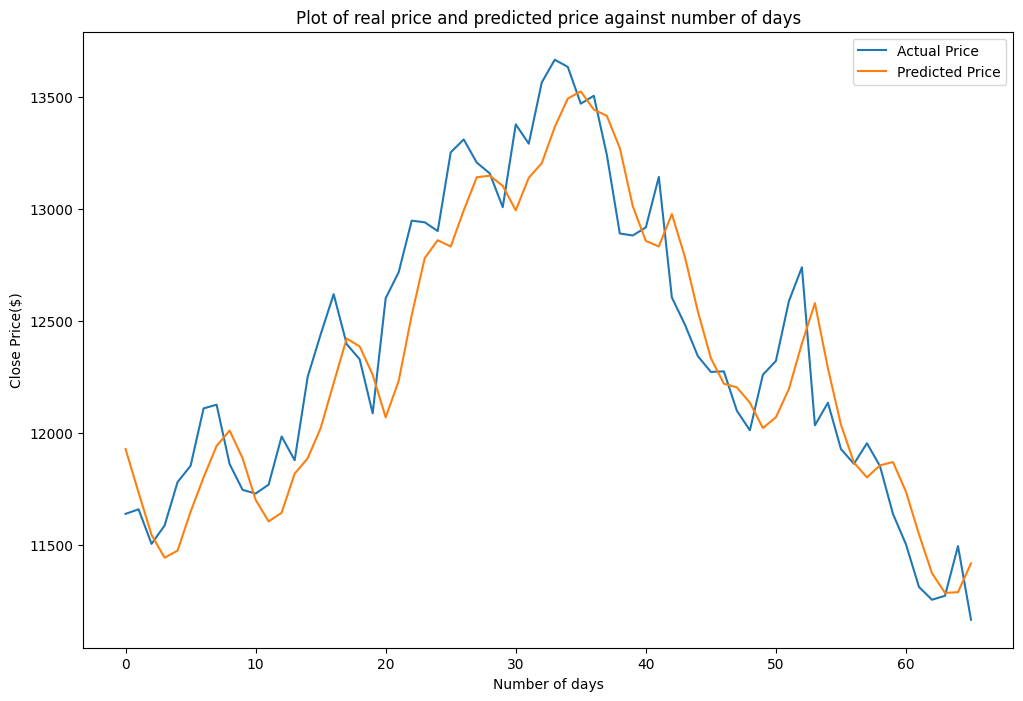

In [54]:
real = plt.plot(y_test, label='Actual Price')
pred = plt.plot(preds, label='Predicted Price')

plt.gcf().set_size_inches(12, 8, forward=True)
plt.title('Plot of real price and predicted price against number of days')
plt.xlabel('Number of days')
plt.ylabel('Close Price($)')

plt.legend(['Actual Price', 'Predicted Price'])
plt.show()    

##LSTM with Sentiment Analysis

In [ ]:
split = (0.85)
sequence_length = 30
epochs = 30
learning_rate = 0.02

In [ ]:
# loading stock price and news data
stock_data = pd.read_csv("microsoft.csv")
news_data = pd.read_csv("sentiment.csv")
stock_column = ['Close']
news_column = ['FinBERT score']

In [ ]:
len_stock_data = stock_data.shape[0]

In [ ]:
# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(stock_column).values[:train_examples]
train_sentiment = news_data.get(news_column).values[:train_examples]
test = stock_data.get(stock_column).values[train_examples:]
test_sentiment = news_data.get(news_column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]
len_train_sentiment = train_sentiment.shape[0]
len_test_sentiment = test_sentiment.shape[0]

In [ ]:
# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)

In [ ]:
# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
len_X_train = len(X_train)
y_train = np.array(train[sequence_length:]).astype(float)

In [ ]:

# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
len_X_test = len(X_test)
y_test = np.array(test[sequence_length:]).astype(float)

In [ ]:
# adding news sentiment to train and test
for i in range(len_X_train):
    X_train[i] = X_train[i].tolist()
    X_train[i].append(train_sentiment[sequence_length + i].tolist())
X_train = np.array(X_train).astype(float)

for i in range(len_X_test):
    X_test[i] = X_test[i].tolist()
    X_test[i].append(test_sentiment[sequence_length + i].tolist())
X_test = np.array(X_test).astype(float)

In [ ]:
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 70, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 10, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss = tf.keras.losses.mean_squared_error,
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )

    model.fit(
        X_train, y_train,
        epochs = epochs
    )

    model.save('name_sentiment.h5')

    return model

In [ ]:
# inverting normaliztion
y_test = scaler.inverse_transform(y_test)

In [ ]:
# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions

In [ ]:
# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    return mae, mape, (1 - mape)

In [ ]:
# trial runs
def run_model(n):
    total_mae = total_mape = total_acc = 0
    for i in range(n):
        model = model_create()
        predictions = predict(model)
        mae, mape, acc = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc 
    return (total_mae / n), (total_mape / n), (total_acc / n),predictions.tolist()

In [ ]:
mae, mape, acc,preds = run_model(1)

Epoch 1/30
7/7 [==============================] - 6s 21ms/step - loss: 0.1325
Epoch 2/30
7/7 [==============================] - 0s 22ms/step - loss: 0.0295
Epoch 3/30
7/7 [==============================] - 0s 22ms/step - loss: 0.0111
Epoch 4/30
7/7 [==============================] - 0s 20ms/step - loss: 0.0094
Epoch 5/30
7/7 [==============================] - 0s 22ms/step - loss: 0.0067
Epoch 6/30
7/7 [==============================] - 0s 21ms/step - loss: 0.0058
Epoch 7/30
7/7 [==============================] - 0s 23ms/step - loss: 0.0038
Epoch 8/30
7/7 [==============================] - 0s 21ms/step - loss: 0.0038
Epoch 9/30
7/7 [==============================] - 0s 22ms/step - loss: 0.0041
Epoch 10/30
7/7 [==============================] - 0s 23ms/step - loss: 0.0038
Epoch 11/30
7/7 [==============================] - 0s 22ms/step - loss: 0.0037
Epoch 12/30
7/7 [==============================] - 0s 22ms/step - loss: 0.0032
Epoch 13/30
7/7 [==============================] - 0s 24ms/st

In [ ]:
print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")

Mean Absolute Error = 6.264886038643973
Mean Absolute Percentage Error = 0.01879930503039379%
Accuracy = 0.9812006949696062


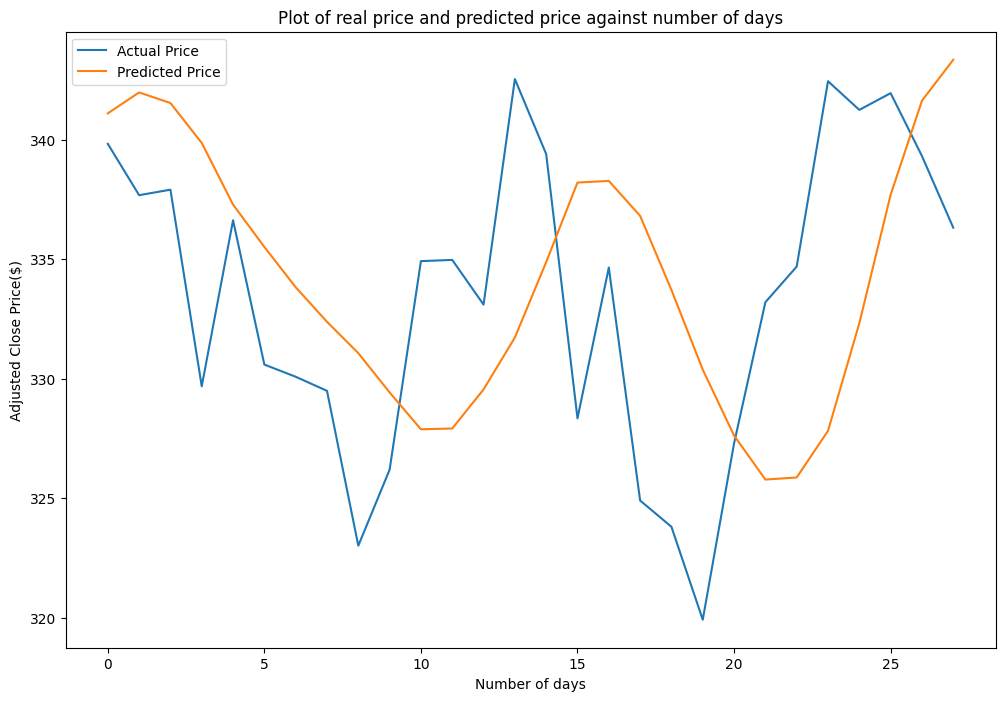

In [ ]:
real = plt.plot(y_test, label='Actual Price')
pred = plt.plot(preds, label='Predicted Price')

plt.gcf().set_size_inches(12, 8, forward=True)
plt.title('Plot of real price and predicted price against number of days')
plt.xlabel('Number of days')
plt.ylabel('Adjusted Close Price($)')

plt.legend(['Actual Price', 'Predicted Price'])
plt.show()